In [6]:
import jax.scipy as jsp
import jax.numpy as jnp
import numdifftools as nd
from kalmanODE_jax import *
from jax.config import config
from jax import grad, jit, partial
from math import sin

config.update("jax_enable_x64", True)

In [7]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
from rodeo.ibm import ibm_init
from rodeo.utils.utils import rand_mat, indep_init, zero_pad
from scipy.integrate import odeint
from rodeo.cython.KalmanODE import KalmanODE as KalmanODE_blas
sys.path.append('../../examples')
from inference.normal import normal as inference

%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


# Graphical Check

In [8]:
def fitz_jax(X_t, t, theta):
    "Fitz ODE written for jax"
    a, b, c = theta
    V, R = X_t[0], X_t[3]
    return jnp.stack([c*(V - V*V*V/3 + R),
                      -1/c*(V - a + b*R)])

In [34]:
def fitz(X_t, t, theta, out=None):
    "FN ODE function with optional overwriting of output."
    if out is None:
        out = np.empty(2)
    a, b, c = theta
    n_deriv1 = len(X_t)//2
    V, R = X_t[0], X_t[n_deriv1]
    out[0] = c*(V - V*V*V/3 + R)
    out[1] = -1/c*(V - a + b*R)
    return out

n_deriv = [1, 1] # Total state
n_obs = 2 # Total measures
n_deriv_prior = [3, 3]
p = sum(n_deriv_prior)
state_ind = [0, 3] # Index of 0th derivative of each state

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0 
tmax = 40
h = 0.01
n_eval = int((tmax-tmin)/h)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 2
sigma = [.1]*n_var

# Initial value, x0, for the IVP
x0 = np.array([-1., 1.])
v0 = np.array([1, 1/3])
X0 = np.ravel([x0, v0], 'F')

# pad the inputs
w_mat = np.array([[0., 1., 0., 0.], [0., 0., 0., 1.]])
W = zero_pad(w_mat, n_deriv, n_deriv_prior)

# function parameter
theta = np.array([0.2, 0.2, 3]) # True theta

ode_init = ibm_init(h, n_deriv_prior, sigma)
x0_state = zero_pad(X0, n_deriv, n_deriv_prior)
kinit = indep_init(ode_init, n_deriv_prior)
kinit2 = dict((k, jnp.array(v)) for k, v in kinit.items())

In [35]:
z_state = rand_mat(2*n_eval, sum(n_deriv_prior))
kalmanode = KalmanODE_blas(W = W, tmin = tmin, tmax = tmax, n_eval = n_eval, ode_fun = fitz, **kinit)
kalmanode.z_state = z_state
ksim_cy = kalmanode.solve_sim(x0_state, theta=theta, method="rodeo")

In [36]:
ksim_jax = \
    solve_sim(fitz_jax, jnp.array(x0_state), tmin, tmax, n_eval, W, **kinit2, z_state=z_state, theta=jnp.array(theta))

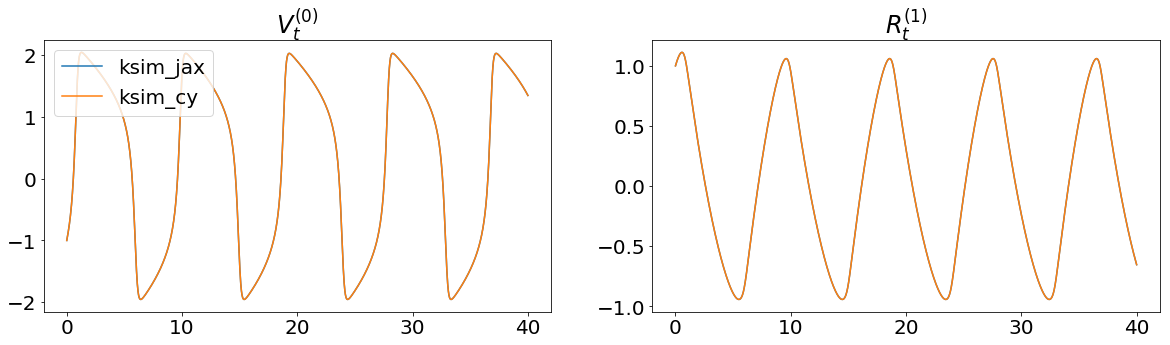

In [37]:
# ode function in odeint format
tseq = np.linspace(tmin, tmax, n_eval+1)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, ksim_jax[:,0], label='ksim_jax')
axs[0].plot(tseq, ksim_cy[:,0], label='ksim_cy')
axs[0].set_title("$V^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, ksim_jax[:,3], label='ksim_jax')
axs[1].plot(tseq, ksim_cy[:,3], label='ksim_cy')
axs[1].set_title("$R^{(1)}_t$")
plt.show()

# Time

In [26]:
%timeit -o _ = \
    solve_sim(fitz_jax, x0_state, tmin, tmax, n_eval, W, \
              **kinit, z_state=z_state, theta=theta).block_until_ready()

2.21 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.21 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [13]:
kalmanode = KalmanODE_blas(W, tmin, tmax, n_eval, fitz, **kinit)
kalmanode.z_state = z_state
kalman_fitz_cy = %timeit -o _ = kalmanode.solve_sim(x0_state, W, theta)

4.03 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


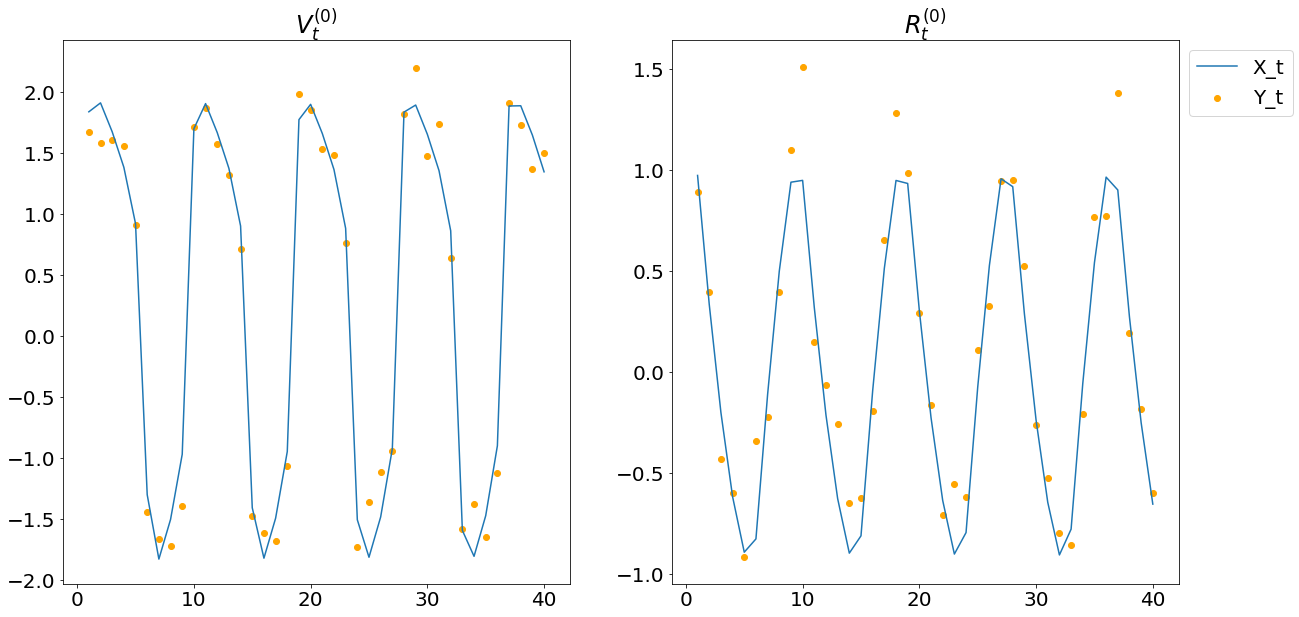

In [12]:
import sys
# logprior parameters
theta_true = jnp.array([0.2, 0.2, 3]) # True theta
n_theta = len(theta_true)
phi_sd = jnp.ones(n_theta) 

# Observation noise
gamma = 0.2

# Number of samples to draw from posterior
n_samples = 100000

# Initialize inference class and simulate observed data
inf = inference(state_ind, tmin, tmax, fitz)
tseq = np.linspace(tmin, tmax, tmax-tmin+1)
Y_t, X_t = inf.simulate(fitz, x0, theta_true, gamma, tseq)
tseq = tseq[1:]
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(tseq, X_t[:,0], label = 'X_t')
axs[0].scatter(tseq, Y_t[:,0], label = 'Y_t', color='orange')
axs[0].set_title("$V^{(0)}_t$")
axs[1].plot(tseq, X_t[:,1], label = 'X_t')
axs[1].scatter(tseq, Y_t[:,1], label = 'Y_t', color='orange')
axs[1].set_title("$R^{(0)}_t$")
axs[1].legend(loc='upper left', bbox_to_anchor=[1, 1])


In [38]:
def loglike(x, mean, var):
    r"Calculate the loglikelihood of the lognormal distribution."
    return jnp.sum(jsp.stats.norm.logpdf(x=x, loc=mean, scale=var))

def kalman_nlpost(phi, Y_t, x0, step_size, phi_mean, phi_sd, gamma):
    r"Compute the negative loglikihood of :math:`Y_t` using the KalmanODE."
    theta = jnp.exp(phi)
    X_t = solve_sim(fitz_jax, x0, tmin, tmax, n_eval, W, **kinit, theta=theta)
    X_t = X_t[::int(1/step_size)][1:][:, state_ind]
    lp = loglike(Y_t, X_t, gamma)
    lp += loglike(phi, phi_mean, phi_sd)
    return -lp

def kalman_nlpost2(phi, Y_t, x0, step_size, phi_mean, phi_sd, gamma):
    r"Compute the negative loglikihood of :math:`Y_t` using the KalmanODE."
    theta = jnp.exp(phi)
    kalmanode = KalmanODE_blas(W, tmin, tmax, n_eval, fitz, **kinit)
    kalmanode.z_state = z_state
    X_t = kalmanode.solve_sim(x0_state, W, theta, method="rodeo")
    X_t = X_t[::int(1/step_size)][1:][:, state_ind]
    lp = loglike(Y_t, X_t, gamma)
    lp += loglike(phi, phi_mean, phi_sd)
    return -lp

In [39]:
phi_mean = jnp.log(theta_true)
phi_init = phi_mean + .1

In [40]:
kalman_grad = jax.grad(kalman_nlpost)
kalman_hes = jax.jacfwd(jax.jacrev(kalman_nlpost))
opt_res = sp.optimize.minimize(kalman_nlpost, phi_init,
                               args=(Y_t, x0_state, h, phi_mean, phi_sd, gamma),
                               method='Newton-CG',
                               jac=kalman_grad)

In [41]:
print("True theta: {}".format(np.exp(phi_mean)))
print("Estimate theta: {}".format(np.exp(opt_res.x)))

True theta: [0.2 0.2 3. ]
Estimate theta: [0.18649361 0.18275138 3.01944847]


In [42]:
opt_res2 = sp.optimize.minimize(kalman_nlpost, phi_init,
                                args=(Y_t, x0_state, h, phi_mean, phi_sd, gamma),
                                method='Nelder-Mead')

In [43]:
print("True theta: {}".format(np.exp(phi_mean)))
print("Estimate theta: {}".format(np.exp(opt_res2.x)))

True theta: [0.2 0.2 3. ]
Estimate theta: [0.18733625 0.17434025 3.02008639]
